# 2D ring resonator

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FRingResonator.ipynb).

This is a simple example of using Tidy3D to perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 2 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform the simulation in just a few minutes.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d.web as web
import tidy3d as td

## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

In [3]:
# define pulse parameters
lambda0 = 0.5
freq0 = td.C_0 /lambda0
fwidth =  freq0 / 6
min_steps_per_wvl = 30
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#mediums)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#structures)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

Compute and visualize the waveguide modes.

In [6]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide],
    run_time=1e-12,
)

mode_spec = td.ModeSpec(num_modes=2)
mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0])
mode_data = mode_solver.solve()

[17:01:42] WARNING  No sources in simulation.                               ]8;id=417241;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=722476;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/components/simulation.py#406\406]8;;\

<Figure size 720x432 with 6 Axes>

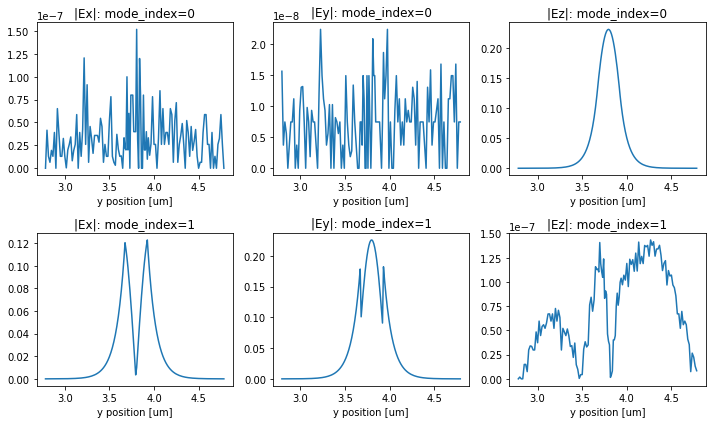

In [7]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
abs(mode_data.fields.Ex.sel(mode_index=0).abs).plot(ax=ax1)
abs(mode_data.fields.Ey.sel(mode_index=0).abs).plot(ax=ax2)
abs(mode_data.fields.Ez.sel(mode_index=0).abs).plot(ax=ax3)
abs(mode_data.fields.Ex.sel(mode_index=1).abs).plot(ax=ax4)
abs(mode_data.fields.Ey.sel(mode_index=1).abs).plot(ax=ax5)
abs(mode_data.fields.Ez.sel(mode_index=1).abs).plot(ax=ax6)
ax1.set_title('|Ex|: mode_index=0')
ax2.set_title('|Ey|: mode_index=0')
ax3.set_title('|Ez|: mode_index=0')
ax4.set_title('|Ex|: mode_index=1')
ax5.set_title('|Ey|: mode_index=1')
ax6.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it.

In [8]:
mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_spec=td.ModeSpec(num_modes=2),
    mode_index=1,
    direction='+'
)

In addition, let's monitor both the fields in plane as well as the output mode amplitudes into the fundamental TE mode.

In [9]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='field')

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(0.4, 0.6, 1001)
freqs_measure = td.C_0 / lambdas_measure

mode_monitor = td.ModeMonitor(
    size=mode_plane.size,
    center=mode_plane.center,
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name='mode'
)

# lets reset the center to the on the right hand side of the simulation though
mode_monitor = mode_monitor.copy(update=dict(center = [+wg_insert_x, wg_center_y, 0]))

Define simulation. [(docs)](https://docs.simulation.cloud/projects/tidy3d/en/latest/api.html#simulation)
To make the simulation 2D, we can just set the simulation size in one of the dimensions to be 0. However, note that we still have to define a grid size in that direction.

In [10]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time_norm,
    boundary_spec=td.BoundarySpec.pml(x=True, y=True)
)

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lambda0),
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, mode_monitor],
    run_time = run_time,
    boundary_spec=td.BoundarySpec.pml(x=True, y=True)
)

----
Visualize structure, source, and modes. [(docs)](https://docs.simulation.cloud/en/latest/howdoi.html#plot-data)

<Figure size 1296x432 with 4 Axes>

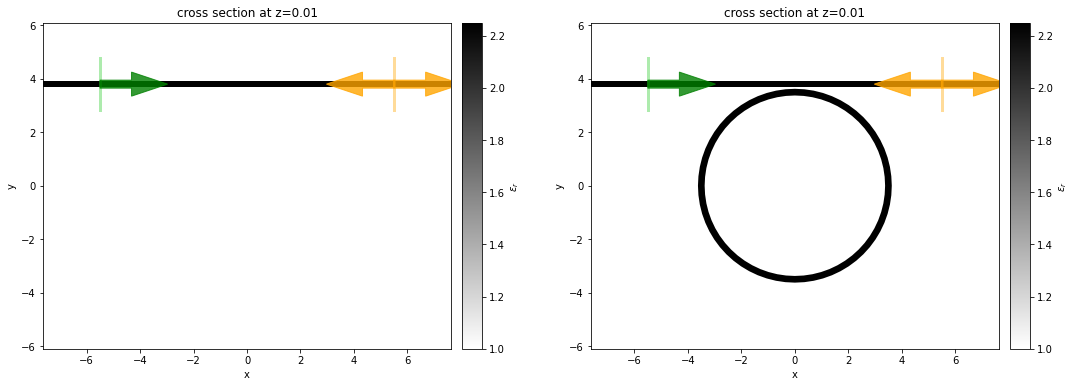

In [11]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sim0.plot_eps(z=0.01, ax=ax1)
sim.plot_eps(z=0.01, ax=ax2)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://docs.simulation.cloud/en/latest/api.html#submitting-simulations)

In [12]:
# use function above to run simulation with and without ring
sim_data0 = web.run(sim0, task_name='normalization', path='data/simulation_data0.hdf5')
sim_data = web.run(sim, task_name='with_ring', path='data/simulation_data.hdf5')

           INFO     Using Tidy3D credentials from stored file                      ]8;id=150462;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=86375;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/auth.py#74\74]8;;\

[17:01:44] INFO     Uploaded task 'normalization' with task_id                  ]8;id=807752;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=126491;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    'd9db1851-d5da-4fae-91da-ee379ef64dd8'.                                  

Output()

[17:01:47] INFO     status = queued                                             ]8;id=589382;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=224068;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

Output()

[17:01:52] INFO     Maximum flex unit cost: 0.20                                ]8;id=796123;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=262751;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#244\244]8;;\

[17:01:55] INFO     status = preprocess                                         ]8;id=731207;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=67884;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#265\265]8;;\

[17:02:04] INFO     starting up solver                                          ]8;id=718301;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=967060;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#269\269]8;;\

[17:02:14] INFO     running solver                                              ]8;id=997290;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=53671;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#275\275]8;;\

Output()

[17:02:18] INFO     early shutoff detected, exiting.                            ]8;id=852432;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=631863;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#286\286]8;;\

           INFO     status = postprocess                                        ]8;id=909330;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=825957;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#292\292]8;;\

Output()

[17:02:32] INFO     status = success                                            ]8;id=379300;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=688231;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#298\298]8;;\

[17:02:33] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=182647;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=789897;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/simulation_data0.hdf5"                                             

Output()

[17:03:02] INFO     loading SimulationData from data/simulation_data0.hdf5      ]8;id=452495;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=897587;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\

[17:03:03] INFO     Uploaded task 'with_ring' with task_id                      ]8;id=46021;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=255991;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '8e7f4f6d-6f34-4dd3-bcb7-a11eb7eec78c'.                                  

Output()

[17:03:06] INFO     status = queued                                             ]8;id=202663;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=418529;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#253\253]8;;\

Output()

[17:03:11] INFO     Maximum flex unit cost: 0.20                                ]8;id=31615;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=723839;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#244\244]8;;\

[17:03:14] INFO     status = preprocess                                         ]8;id=170781;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=753110;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#265\265]8;;\

[17:03:23] INFO     starting up solver                                          ]8;id=631097;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=154814;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#269\269]8;;\

[17:03:34] INFO     running solver                                              ]8;id=924510;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=751741;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#275\275]8;;\

Output()

[17:04:11] INFO     early shutoff detected, exiting.                            ]8;id=102093;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=131836;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#286\286]8;;\

           INFO     status = postprocess                                        ]8;id=988613;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=14748;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#292\292]8;;\

Output()

[17:04:29] INFO     status = success                                            ]8;id=21963;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=249204;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#298\298]8;;\

[17:04:30] INFO     downloading file "output/monitor_data.hdf5" to              ]8;id=549121;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=736945;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#574\574]8;;\
                    "data/simulation_data.hdf5"                                              

Output()

[17:05:06] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=403290;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=996078;file:///home/shashwat/flexcompute/repositories/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#398\398]8;;\

In [13]:
print(sim_data0.log)

Simulation domain Nx, Ny, Nz: [1375, 741, 1]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.0231e+06.
Using subpixel averaging: True
Number of time steps: 4.7330e+03
Automatic shutoff factor: 1.00e-05
Time step (s): 2.1135e-17


Compute source modes time (s):     0.2220
Compute monitor modes time (s):    2.6835
Rest of setup time (s):            4.2628

Running solver for 4733 time steps...
- Time step    189 / time 3.99e-15s (  4 % done), field decay: 1.00e+00
- Time step    377 / time 7.97e-15s (  7 % done), field decay: 1.00e+00
- Time step    378 / time 7.99e-15s (  8 % done), field decay: 1.00e+00
- Time step    567 / time 1.20e-14s ( 12 % done), field decay: 1.00e+00
- Time step    757 / time 1.60e-14s ( 16 % done), field decay: 9.96e-01
- Time step    946 / time 2.00e-14s ( 20 % done), field decay: 9.96e-01
- Time step   1135 / time 2.40e-14s ( 24 % done), field decay: 9.94e-01
- Time step   1325 / time 2.80e-14s ( 28 % done), field decay: 9.94e-01
- Time s

<Figure size 1080x720 with 8 Axes>

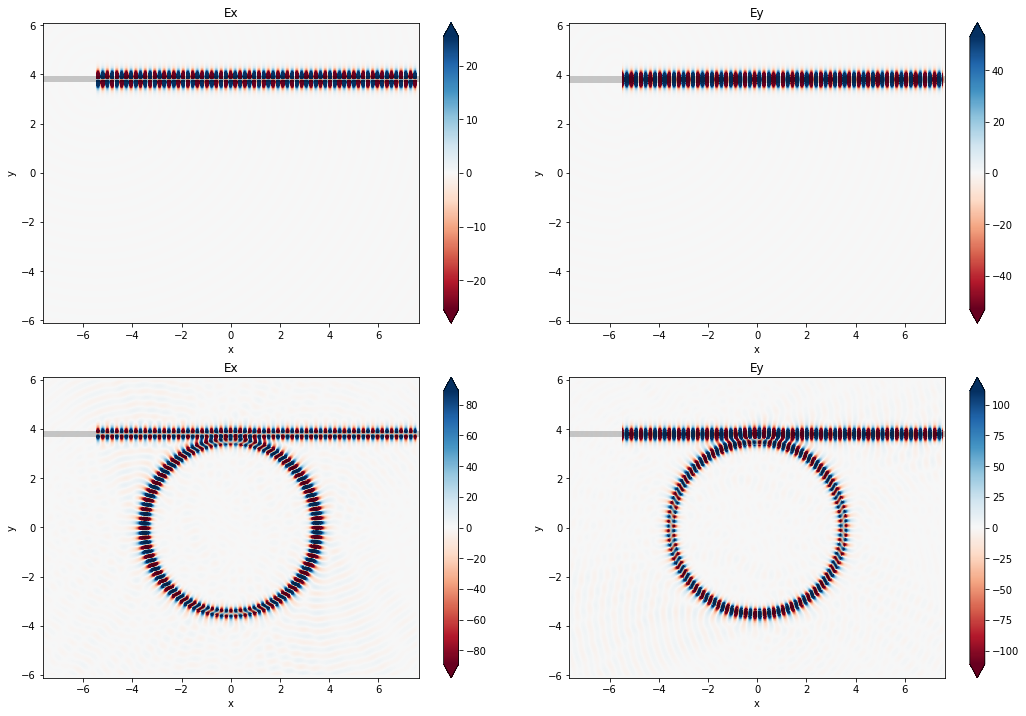

In [14]:
# visualize normalization run
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(15, 10))

ax1 = sim_data0.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax1)
ax2 = sim_data0.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax2)
ax1.set_title('Ex')
ax2.set_title('Ey')

ax3 = sim_data.plot_field('field', 'Ex', val='real', z=0, freq=freq0, ax=ax3)
ax4 = sim_data.plot_field('field', 'Ey', val='real', z=0, freq=freq0, ax=ax4)
ax3.set_title('Ex')
ax4.set_title('Ey')

plt.show()

## Analyze Spectrum

Now let's analyze the mode amplitudes in the output waveguide.

First, let's grab the data to inspect it.

In [15]:
sim_data['mode']

ModeData(type='ModeData', data_dict={'amps': ModeAmpsData(type='ModeAmpsData', values=array([[[-1.36748595e-08-3.54299805e-07j,
          6.67187296e-01-7.32922290e-01j],
        [-3.91183705e-07+8.80675735e-08j,
          5.30794930e-01-8.35484975e-01j],
        [-7.61546932e-08-5.03426656e-07j,
          3.88862407e-01-9.08825832e-01j],
        ...,
        [ 1.31547302e-08-4.17567149e-09j,
         -8.79975414e-01-4.26730958e-01j],
        [-2.83325274e-07-1.08636654e-07j,
         -9.25109939e-01-3.18559222e-01j],
        [-6.25343250e-08-2.55287750e-08j,
         -9.56228774e-01-2.08281329e-01j]],

       [[-5.21015333e-10+6.64221637e-10j,
         -6.40159271e-06+8.28102695e-06j],
        [-3.41120027e-09+5.05742228e-09j,
         -9.31455451e-06-1.61433922e-05j],
        [ 2.37012830e-09-6.24865849e-09j,
          2.39816467e-06-1.55517018e-05j],
        ...,
        [ 2.19387902e-09+7.91885295e-10j,
          1.57870538e-05-4.19278858e-05j],
        [-7.99745318e-09-2.91163112e-09j,
          1.09425509e-05-4.27140064e-05j],
        [-3.55634820e-10-1.56853308e-10j,
          1.17555646e-06-4.32657027e-05j]]]), data_attrs={'units': 'sqrt(W)', 'long_name': 'mode amplitudes'}, f=array([7.49481146e+14, 7.49106593e+14, 7.48732414e+14, ...,
       4.99987423e+14, 4.99820705e+14, 4.99654098e+14]), mode_index=array([0, 1]), direction=['+', '-']), 'n_complex': ModeIndexData(type='ModeIndexData', values=array([[1.3983288+0.j, 1.3546187+0.j],
       [1.3982598+0.j, 1.354504 +0.j],
       [1.3981907+0.j, 1.3543893+0.j],
       ...,
       [1.331268 +0.j, 1.2425503+0.j],
       [1.331204 +0.j, 1.2424469+0.j],
       [1.33114  +0.j, 1.2423441+0.j]], dtype=complex64), data_attrs={'units': '', 'long_name': 'effective index'}, f=array([7.49481146e+14, 7.49106593e+14, 7.48732414e+14, ...,
       4.99987423e+14, 4.99820705e+14, 4.99654098e+14]), mode_index=array([0, 1]))})

As we see, the mode amplitude data is complex-valued with three 3 dimensions:

- index into the mode order returned by solver (remember, we wanted mode_index=1 for fundamental TE).

- direction of the propagation (for decomposition).

- frequency.

Let's select into the first two dimensions to get mode amplitudes as a function of frequency and divide the results with a ring by the normalization.

In [16]:
mode_data = sim_data['mode'].amps.sel(mode_index=1, direction='+')
mode_data0 = sim_data0['mode'].amps.sel(mode_index=1, direction='+')
transmission_amps = mode_data / mode_data0

Now let's plot the data.

<Figure size 720x360 with 1 Axes>

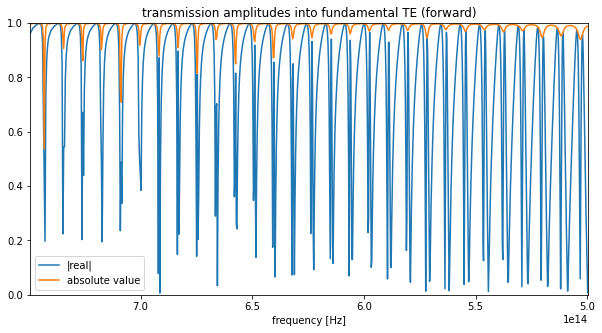

In [17]:
f, ax = plt.subplots(figsize=(10, 5))
abs(transmission_amps.real).plot.line(x='f', ax=ax, label='|real|')
# abs(transmission_amps.imag).plot.line(x='f', ax=ax, label='|imag|')
abs(transmission_amps).plot.line(x='f', ax=ax, label='absolute value')
ax.legend()
ax.set_title('transmission amplitudes into fundamental TE (forward)')
ax.set_ylim(0, 1)
ax.set_xlim(freqs_measure[0], freqs_measure[-1])
plt.show()